In [2]:
import argparse
import logging
import time
import datetime
from os.path import exists

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceEnum_ELBO, TraceTMC_ELBO, config_enumerate
from pyro.optim import ClippedAdam

import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage

from midi2audio import FluidSynth

import pretty_midi
from scipy.io import wavfile

import wave
from scipy.io.wavfile import write
import fluidsynth

In [3]:
## args
num_epochs=5000
learning_rate=0.003
rpt_eps = 1e-20
rnn_clamp = 1.
# learning_rate=0.0003
beta1=0.96
beta2=0.999
clip_norm=10.0
lr_decay=0.99996
mini_batch_size=20
annealing_epochs=1000
minimum_annealing_factor=0.2
rnn_dropout_rate=0.1
num_iafs=0
iaf_dim=100
checkpoint_freq=100
load_opt=''
load_model=''
save_opt=''
save_model=''
cuda=False
jit=False
tmc=False
tmcelbo=False
rpt = True
tmc_num_samples=10
log='dmm.log'


In [4]:
## 長さ最長129、例えば長さが60のやつは61~129はすべて0データ
data = poly.load_data(poly.JSB_CHORALES)
training_seq_lengths = data['train']['sequence_lengths']
training_data_sequences = data['train']['sequences']

## super easy training set
training_seq_lengths = torch.tensor([8])
training_data_sequences = torch.zeros(10,8,88)
for i in range(5):
    for j in range(8):
        training_data_sequences[i][j][int(20+i*10)] = 1
for i in range(5,8):
    training_data_sequences[i][0][int(110-i*10)  ] = 1
    training_data_sequences[i][1][int(110-i*10)+2] = 1
    training_data_sequences[i][2][int(110-i*10)+2] = 1
    training_data_sequences[i][3][int(110-i*10)+1] = 1
    training_data_sequences[i][4][int(110-i*10)+2] = 1
    training_data_sequences[i][5][int(110-i*10)+2] = 1
    training_data_sequences[i][6][int(110-i*10)+2] = 1
    training_data_sequences[i][7][int(110-i*10)+1] = 1

test_seq_lengths = data['test']['sequence_lengths']
test_data_sequences = data['test']['sequences']
val_seq_lengths = data['valid']['sequence_lengths']
val_data_sequences = data['valid']['sequences']
N_train_data = len(training_seq_lengths)
N_train_time_slices = float(torch.sum(training_seq_lengths))
N_mini_batches = int(N_train_data / mini_batch_size +
                    int(N_train_data % mini_batch_size > 0))


# how often we do validation/test evaluation during training
val_test_frequency = 50
# the number of samples we use to do the evaluation
n_eval_samples = 1

# rep is short for "repeat"
# which means how many times we use certain sample to do validation/test evaluation during training
def rep(x):
        rep_shape = torch.Size([x.size(0) * n_eval_samples]) + x.size()[1:]
        repeat_dims = [1] * len(x.size())
        repeat_dims[0] = n_eval_samples
        return x.repeat(repeat_dims).reshape(n_eval_samples, -1).transpose(1, 0).reshape(rep_shape)

# get the validation/test data ready for the dmm: pack into sequences, etc.
val_seq_lengths = rep(val_seq_lengths)
test_seq_lengths = rep(test_seq_lengths)
val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths = poly.get_mini_batch(
    torch.arange(n_eval_samples * val_data_sequences.shape[0]), rep(val_data_sequences),
    val_seq_lengths, cuda=cuda)
test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths = poly.get_mini_batch(
    torch.arange(n_eval_samples * test_data_sequences.shape[0]), rep(test_data_sequences),
    test_seq_lengths, cuda=cuda)

# Emitter

In [5]:
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`
    """

    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution `p(x_t|z_t)`
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = torch.sigmoid(self.lin_hidden_to_input(h2))
        return ps

# Transmitter

In [6]:
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in the reference for comparison.
    """

    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale


# Combiner

In [7]:
class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, x_{t:T})`, which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on `x_{t:T}` is
    through the hidden state of the RNN (see the PyTorch module `rnn` below)
    """

    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale


# Deep Markov Model

In [8]:
class DMM(nn.Module):
    """
    This PyTorch Module encapsulates the model as well as the
    variational distribution (the guide) for the Deep Markov Model
    """

    def __init__(self, input_dim=88, z_dim=100, emission_dim=100,
                 transition_dim=200, rnn_dim=600, num_layers=1, rnn_dropout_rate=0.1,
                 num_iafs=0, iaf_dim=50, use_cuda=False):
        super().__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        # dropout just takes effect on inner layers of rnn
        rnn_dropout_rate = 0. if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim, nonlinearity='relu',
                          batch_first=True, bidirectional=False, num_layers=num_layers,
                          dropout=rnn_dropout_rate)

        # if we're using normalizing flows, instantiate those too
        self.iafs = [affine_autoregressive(z_dim, hidden_dims=[iaf_dim]) for _ in range(num_iafs)]
        self.iafs_modules = nn.ModuleList(self.iafs)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all PyTorch (sub)modules
        if use_cuda:
            self.cuda()

    def forward(self, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths, annealing_factor=1.0):

        # this is the number of time steps we need to process in the mini-batch
        T_max = mini_batch.size(1)

        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, mini_batch.size(0), self.rnn.hidden_size).contiguous()
        # if any(torch.isnan(h_0_contig.reshape(-1))):
        #     print("h_0_contig")
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        if any(torch.isnan(rnn_output.data.reshape(-1))):
            print("rnn_output First")
            # print(self.rnn.state_dict().items())
            print(rnn_output)
            torch.save(rnn_output, "out")
            torch.save(self.rnn.state_dict().items, "dic")
            torch.save(mini_batch_reversed, "mini_batch_reversed")
            torch.save(h_0_contig, "h_0_contig")
            assert False

        # reverse the time-ordering in the hidden state and un-pack it
        rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)
        # if any(torch.isnan(rnn_output.reshape(-1))):
        #     print("rnn_output")
        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        # if any(torch.isnan(z_prev.reshape(-1))):
        #     print("z_prev")

        x_container = []
        for t in range(1,T_max+1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])

            # Reparameterization Trick
            eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps

            # compute the probabilities that parameterize the bernoulli likelihood
            emission_probs_t = self.emitter(z_t)

            # the next statement instructs pyro to observe x_t according to the
            # bernoulli distribution p(x_t|z_t)

            # No Reparameterization Trick
            x = emission_probs_t

            #Reparameterization Trick
            if rpt : 
                eps = torch.rand(88)
                # assert len(emission_probs_t) == 88
                appxm = torch.log(eps + rpt_eps) - torch.log(1-eps + rpt_eps) + torch.log(x + rpt_eps) - torch.log(1-x + rpt_eps)
                # appxm = torch.log(eps) - torch.log(1-eps) + torch.log(x) - torch.log(1-x)
                x = torch.sigmoid(appxm)

                

            # the latent sampled at this time step will be conditioned upon
            # in the next time step so keep track of it
            z_prev = z_t
            x_container.append(x)

        x_container = torch.stack(x_container)
        return x_container.transpose(0,1)
                

# Wasserstein Distance ( WGAN version )

In [9]:
class WGAN_network(nn.Module):
    def __init__(self, hiddden_dim=256):
        super().__init__()

        ## the number of tones
        self.song_size = 88

        self.hidden_size = hiddden_dim
        self.D =  nn.Sequential(
                    nn.Linear(self.song_size, self.hidden_size),
                    nn.LeakyReLU(0.2),
                    nn.Linear(self.hidden_size, 1))
    
    def forward(self, train_mini_batch, generated_mini_batch):
        outputs_real = self.D(train_mini_batch)
        outputs_fake = self.D(generated_mini_batch)
        # print(outputs_real.size())
        # print(outputs_real.size())        
        # if any(torch.isnan(outputs_real.reshape(-1))):
        #     print("REAL")
        # if any(torch.isnan(generated_mini_batch.reshape(-1))):
        #     print("GENERATED")
        # if any(torch.isnan(outputs_fake.reshape(-1))):
        #     print("FAKE")
        # if torch.isnan(-(torch.mean(outputs_real) - torch.mean(outputs_fake))):
        #     print("OUTPUT")
        return -(torch.mean(outputs_real) - torch.mean(outputs_fake))



class WassersteinLoss():
    def __init__(self, WGAN_network, N_loops=5, lr=0.00001):
        self.WGAN_network = WGAN_network
        self.D = self.WGAN_network.D
        # self.optimizer = torch.optim.RMSprop(self.D.parameters(), lr=lr)
        self.optimizer = torch.optim.Adam(self.D.parameters(), lr=lr)
        # the number of loops of calculation of Wass
        self.N_loops = N_loops


    def calc(self, train_mini_batch, generated_mini_batch):
        # vanish grad_fn of DMM's parameters
        no_grad_generated_mini_batch = torch.tensor(generated_mini_batch)

        # activate grad_fn of Wass calculator's parameters 
        for p in self.D.parameters():
                p.requires_grad = True

        ### CALCULATION LOOP ###       
        for i in range(self.N_loops):
            # print("{0}%".format(i*20))
            # NaN_detect(self.D,i,"Before calc")
            loss = self.WGAN_network(train_mini_batch, no_grad_generated_mini_batch)
            # print(loss)
            self.optimizer.zero_grad()
            loss.backward() # 勾配を計算
            self.optimizer.step() # 重みパラメータを更新 (Algorithm 1のStep 6)

            # NaN_detect(self.D,i,"Before Clip")
            # 重みパラメータの値を-0.01から0.01の間にクリッピングする (Algorithm 1のStep 7)
            for p in self.D.parameters():
                p.data.clamp_(-0.01, 0.01)
            # NaN_detect(self.D,i,"After Clip")            

        # vanish grad_fn of Wass calculator's parameters
        # because we don't need to update Wass calculator's parameters anymore
        for p in self.D.parameters():
                p.requires_grad = False

        # calculate Wass without Wass calculator's parameters's grad_fn
        loss = self.WGAN_network(train_mini_batch, generated_mini_batch)

        # save model
        # torch.save(self.D.state_dict(), "D")

        # Wass is positive
        return -loss


# Set the DMM and the Optimizer

In [10]:
dmm = DMM()
WN = WGAN_network()
W = WassersteinLoss(WN)

# Create optimizer algorithm
optimizer = optim.Adam(dmm.parameters(), lr=learning_rate)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# make directory for Data
now = datetime.datetime.now().strftime('%Y%m%d_%H_%M')
os.makedirs("saveData\\"+datetime.datetime.now().strftime('%Y%m%d_%H_%M'))

num_epochs = 1000
checkpoint_freq = 500
#######################
#### TRAINING LOOP ####
#######################
times = [time.time()]
losses = []
for epoch in range(num_epochs):
    epoch_nll = 0
    shuffled_indices = torch.randperm(N_train_data)
    # print("Proceeding: %.2f " % (epoch*100/5000) + "%")

    # process each mini-batch; this is where we take gradient steps
    for which_mini_batch in range(N_mini_batches):

        # compute which sequences in the training set we should grab
        mini_batch_start = (which_mini_batch * mini_batch_size)
        mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size, N_train_data])
        mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

        # grab a fully prepped mini-batch using the helper function in the data loader
        mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
            = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                                    training_seq_lengths, cuda=cuda)

        # reset gradients
        optimizer.zero_grad()

        # generate mini batch from training mini batch
        # NaN_detect(dmm, epoch, message="Before Generate")                          
        generated_mini_batch = dmm(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
        # NaN_detect(dmm, epoch, message="After Generate")
        # if any(torch.isnan(generated_mini_batch.reshape(-1))):
        #     print("GENERATED")
        #     assert False
        # NaN_detect(WN, epoch, message="calc_Before")
        # calculate loss
        loss = W.calc(test_batch, generated_mini_batch)
        # NaN_detect(WN, epoch, message="calc_After")

        # NaN_detect(dmm, epoch, message="step_Before")        
        # do an actual gradient step
        loss.backward()
        optimizer.step()
        scheduler.step()
        for p in dmm.rnn.parameters():
            p.data.clamp_(-rnn_clamp, rnn_clamp)
            # p.data.clamp_(-0.001, 0.001)
        # NaN_detect(dmm, epoch, message="step_After")        

        epoch_nll += loss
    
    # report training diagnostics
    times.append(time.time())
    losses.append(epoch_nll)
    epoch_time = times[-1] - times[-2]
    # logging.info("[training epoch %04d]  %.4f \t\t\t\t(dt = %.3f sec)" %
    #                 (epoch, epoch_nll / N_train_time_slices, epoch_time))
    if (epoch+1) % 100 == 0:
        print("epoch %d time : %d sec" % (epoch+1, int(epoch_time)))
        print("        loss : %f " % epoch_nll)
        # torch.save(dmm.state_dict, "DMM_dic")

    if epoch % checkpoint_freq == 0 :
        saveDic = {
            "DMM_dic": dmm.state_dict
        }
        torch.save(saveDic,"saveData\\" + now + "\dic_epoch%d"%(epoch+1))
    elif epoch == num_epochs-1:
        saveDic = {
            "DMM_dic": dmm.state_dict,
            "WGAN_Network_dic": WN.state_dict,
            "epoch_times": times,
            "losses":losses,
            # "args": args
        }
        torch.save(saveDic,"saveData\\" + now + "\dic_epoch%d"%(epoch+1))

        ## save plot ##
        FS = 10
        fig = plt.figure()
        plt.rcParams["font.size"] = FS
        plt.plot(saveDic["losses"])
        plt.title("Wasserstein Loss")
        plt.xlabel("epoch", fontsize=FS)
        plt.ylabel("loss", fontsize=FS)
        fig.savefig("saveData\\" + now + "\LOSS.png")
    


KeyboardInterrupt: 

# NaN detector

In [12]:
def NaN_detect(NetWork, epoch, message=None):
    flag = False
    for name, site in NetWork.state_dict().items():
        if any(torch.isnan(site.reshape(-1))):
            flag = True
            # if message != None:
            #     print(message)
            # print("Nan was detected!! at epoch %d" % epoch)
            # print("Para name is %s" % name)
    if flag:
        if message != None:
            print(message)
        assert False

# Generate audio data from trained DMM

## Make and Save midi

In [13]:
def save_as_midi(song, length, path="", name="default.mid", BPM = 120, interval = 120, velocity = 127):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(MetaMessage('set_tempo', tempo=mido.bpm2tempo(BPM)))
    for tones in song:
        which_tone = (tones == 1).nonzero().reshape(-1)
        if len(which_tone) == 0:
            track.append(Message('note_on', note=0, velocity=0, time=0))
            track.append(Message('note_off', note=0, time=interval))
        else:
            for which in which_tone:
                track.append(Message('note_on', note=int(which), velocity=velocity, time=0))
            for which in which_tone:
                track.append(Message('note_off', note=int(which), time=interval))
    mid.save(os.path.join(path, name))

In [14]:
def save_as_midi(song, path="", name="default.mid", BPM = 120, velocity = 100):
    pm = pretty_midi.PrettyMIDI(resolution=960, initial_tempo=BPM) #pretty_midiオブジェクトを作ります
    instrument = pretty_midi.Instrument(0) #instrumentはトラックみたいなものです。
    for i,tones in enumerate(song):
        which_tone = (tones == 1).nonzero().reshape(-1)
        print(which_tone)
        if len(which_tone) == 0:
            note = pretty_midi.Note(velocity=0, pitch=0, start=i, end=i+1) #noteはNoteOnEventとNoteOffEventに相当します。
            instrument.notes.append(note)
        else:
            for which in which_tone:
                note = pretty_midi.Note(velocity=velocity, pitch=int(which), start=i, end=i+1) #noteはNoteOnEventとNoteOffEventに相当します。
                instrument.notes.append(note)
                print("DONE")

    pm.instruments.append(instrument)
    pm.write(os.path.join(path, name)) #midiファイルを書き込みます。


def midi_to_wav(midi_name, midi_path="", wav_name = None, wav_path="", rate=44100):
    if wav_name == None:
        wav_name = os.path.splitext(midi_name)[0]+ ".wav"
        print(wav_name)
    midi_data = pretty_midi.PrettyMIDI(midi_name) #midiファイルを読み込みます
    data = np.array(midi_data.synthesize()*1e5, dtype = "int16")
    write(os.path.join(wav_path, wav_name), rate, data )

In [15]:
# generate X
def generate_Xs(dmm, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths):
    songs_dic = {}
    generated_mini_batch = dmm(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
    for i, song in enumerate(generated_mini_batch):
        tones_container = []
        for time in range(mini_batch_seq_lengths[i]):
            print(song[time])
            p = dist.Bernoulli(probs=song[time])
            tone = p.sample()
            tones_container.append(tone)
        tones_container = torch.stack(tones_container)
        songs_dic.update([("song%02d"%(i), tones_container)])
    return songs_dic


In [16]:
No = 0
song = songs["song%02d"%No]
lengthG = len(song)
save_as_midi(song=song, name= "Gen.mid")
midi_to_wav(midi_name="Gen.mid")

NameError: name 'songs' is not defined

## Listen midi

In [17]:
def listen_midi(name, path=""):
    ports = mido.get_output_names()
    print("START")
    with mido.open_output(ports[0]) as outport:
        for msg in mido.MidiFile(os.path.join(path,name)):
            time.sleep(msg.time)
            if not msg.is_meta:
                # print(outport, msg)
                outport.send(msg)
    print("END")

## Prepare mini batch for genetating

In [19]:
shuffled_indices = torch.randperm(N_train_data)
# print("Proceeding: %.2f " % (epoch*100/5000) + "%")

# process each mini-batch; this is where we take gradient steps
which_mini_batch = 0

# compute which sequences in the training set we should grab
mini_batch_start = (which_mini_batch * mini_batch_size)
mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size, N_train_data])
mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

# grab a fully prepped mini-batch using the helper function in the data loader
mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
    = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                            training_seq_lengths, cuda=cuda)


In [42]:
path = os.path.join("saveData", "20210108_22_40")
# path = os.path.join("saveData", "20210115_12_21")
DMM_dics = torch.load(os.path.join(path,"dic_epoch10000"))
DMM_dic = DMM_dics["DMM_dic"]

In [21]:
# Load dictionary from trained dmm
# DMM_dic = torch.load("DMM_dic")
dmm = DMM()
dmm.load_state_dict(DMM_dic())

In [22]:
songs = generate_Xs(dmm, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)

tensor([1.0094e-20, 3.4407e-20, 5.9592e-22, 5.5047e-20, 1.1814e-21, 1.6529e-20,
        2.7930e-21, 8.2927e-20, 8.1620e-21, 1.4497e-20, 4.3196e-20, 6.4315e-21,
        7.3374e-21, 1.9560e-18, 4.2507e-20, 6.0453e-21, 5.3941e-21, 3.7229e-21,
        3.2609e-22, 9.6292e-21, 9.2933e-20, 2.2613e-21, 4.4191e-21, 8.1315e-21,
        2.3166e-21, 3.2474e-21, 1.4908e-20, 1.4407e-20, 8.6003e-21, 1.4590e-20,
        6.0835e-22, 2.0210e-20, 1.1373e-20, 2.8997e-21, 1.6675e-19, 2.7123e-20,
        6.2462e-21, 6.9517e-21, 1.8018e-21, 4.5659e-21, 1.1716e-20, 3.4917e-20,
        1.8491e-20, 1.4841e-20, 5.4882e-20, 1.3823e-22, 1.3598e-21, 3.4827e-22,
        2.9814e-20, 1.4945e-20, 2.3046e-20, 2.4473e-20, 9.9684e-21, 5.9925e-21,
        5.2138e-21, 6.2475e-21, 3.6686e-21, 4.5369e-21, 3.2609e-20, 1.6676e-20,
        1.6149e-20, 1.0000e+00, 2.2849e-21, 1.7974e-21, 3.9153e-21, 1.2455e-19,
        5.1309e-03, 2.6532e-19, 2.4282e-21, 8.1504e-22, 2.6426e-20, 8.0360e-22,
        2.9089e-22, 3.1272e-21, 1.5376e-

In [23]:
print(songs["song%02d"%No])
print(mini_batch[No])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0

In [27]:
No = 0
song = songs["song%02d"%No]
lengthG = len(song)
save_as_midi(song=song, length = lengthG, name= "Gen.mid",interval=360)

song = mini_batch[No]
lengthT = mini_batch_seq_lengths[No]
save_as_midi(song=song, length = lengthT, name="Tra.mid", interval=360)

# song = training_data_sequences[0]
# lengthT = 8
# save_as_midi(song=song, length = lengthT, name="Tra.mid",interval=240)

if lengthG == lengthT:
    print(lengthG)
else:
    assert False

TypeError: save_as_midi() got an unexpected keyword argument 'length'

In [51]:
# path = os.path.join("saveData", "20210108_22_40")
path = os.path.join("saveData", "20210115_12_21")
epoch_number = 20000
# listen_midi("test.mid")
# listen_midi("Gen.mid")
listen_midi(os.path.join(path, "Training_Epoch%d.mid"%epoch_number))
listen_midi(os.path.join(path, "Generated_Epoch%d.mid"%epoch_number))

START
END
START
END


# Dipict Loss

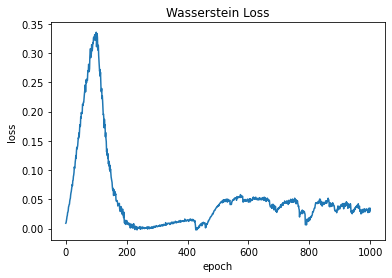

In [35]:
FS = 10
fig = plt.figure()
plt.rcParams["font.size"] = FS
plt.plot(DMM_dics["losses"])
plt.title("Wasserstein Loss")
plt.xlabel("epoch", fontsize=FS)
plt.ylabel("loss", fontsize=FS)
fig.savefig("test.png")
# plt.xlim(500,2000)
# plt.ylim(0,0.06)
# DMM_dics["losses"][2000]

In [751]:
DMM_dics["losses"][999]

tensor(0.0352, requires_grad=True)

## args

In [30]:
DMM_dics["args"]

Namespace(annealing_epochs=1000, beta1=0.96, beta2=0.999, checkpoint_freq=1000, clip_norm=10.0, cuda=False, iaf_dim=100, jit=False, learning_rate=5e-05, load_model='', load_opt='', log='dmm.log', lr_decay=0.99996, mini_batch_size=20, minimum_annealing_factor=0.2, num_epochs=10000, num_iafs=0, rnn_clamp=0.01, rnn_dropout_rate=0.1, rpt=True, rpt_eps=1e-20, save_model='', save_opt='', tmc=False, tmc_num_samples=10, tmcelbo=False, w_loops=10, wass_learning_rate=1e-05, weight_decay=2.0)

# Save as MP3

In [4]:
# サウンドフォントを指定する
# fs = FluidSynth(sound_font='font.sf2')
fs = FluidSynth()
# 入力するmidiファイルとアウトプットファイル
fs.midi_to_audio("TEST.mid", 'sample.wav')

FileNotFoundError: [WinError 2] 指定されたファイルが見つかりません。